# Urban Green Spaces and Health: A Geospatial Analysis of Parks, Socioeconomic Factors, and Influenza-like Illness in NYC

Abstract: In this urban data analysis study, we aim to explore the interplay between the availability of parks and recreational areas, the accessibility of seasonal flu vaccination centers, and their combined impact on public health in New York City. Given the growing evidence linking access to green spaces with improved health outcomes and the critical role of flu vaccinations in preventing seasonal outbreaks, this analysis seeks to provide a comprehensive overview of how these factors interact across different income levels and neighborhoods.

### Project Aim:

1. Analyze the Spatial Distribution of Parks and Seasonal Flu Vaccination Centers in NYC: Investigate the geographical spread of parks and recreational areas as well as flu vaccination centers across New York City to understand their accessibility in different neighborhoods.

2. Correlate Park and Vaccination Center Accessibility with Socioeconomic Factors: Examine how the accessibility of parks and flu vaccination centers correlates with the socioeconomic factors of surrounding neighborhoods. This includes analyzing income levels and other relevant demographic data to assess disparities in access.

3. Investigate the Relationship Between Parks, Vaccination Centers, Socioeconomic Factors, and Public Health Outcomes

### Hypothesis 1A: 

Neighborhoods with greater access to parks and recreational areas will exhibit lower rates of emergency department visits and admissions for influenza-like illnesses and pneumonia.

### Hypothesis 1B:

There is a disparity in the accessibility of seasonal flu vaccination centers, with lower-income neighborhoods having fewer vaccination centers per capita. 

### Hypothesis 1C:

The combined availability of parks and flu vaccination centers in a neighborhood correlates positively with better public health outcomes, particularly in terms of reduced incidence of influenza-like illnesses. 

In [1]:
# Import needed packages
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import re
import matplotlib.pyplot as plt
from sodapy import Socrata
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

### Part I: Data Import and Cleaning

### 1. NYC Map Shapefile

In [2]:
# File path for NYC zipcode
zip_code_path = 'data/ZIPCODE/ZIP_CODE_040114.shp'

# Read the shapefile
zip_codes = gpd.read_file(zip_code_path)

Note: The counties and boroughs are synonymous in NYC. 'New York' county corresponds to Manhattan, 'Kings' to Brooklyn, 'Richmond' to Staten Island

In [3]:
# Replace borough names
zip_codes = zip_codes.rename(columns={'COUNTY': 'Borough'})
zip_codes['Borough'] = zip_codes['Borough'].replace({
    'New York': 'Manhattan',
    'Kings': 'Brooklyn',
    'Richmond': 'Staten Island'
})

In [4]:
# Group by borough and sum 'POPULATION'
population_per_borough = zip_codes.groupby('Borough')['POPULATION'].sum()
# Convert population_per_borough to a DataFrame
population_per_borough = population_per_borough.reset_index()
population_per_borough.columns = ['Borough', 'Population']
population_per_borough

,Borough,Population
0,Bronx,1431301.0
1,Brooklyn,2548896.0
2,Manhattan,1687421.0
3,Queens,2262768.0
4,Staten Island,468220.0


### 2. Personal Income Tax Filers 2015 through 2021 - NYC Open Data
https://data.ny.gov/Government-Finance/Personal-Income-Tax-Filers-Summary-Dataset-1-Major/73iw-kuxv/data

In [5]:
client = Socrata("data.ny.gov", None)
results = client.get("73iw-kuxv", limit=3000)
# Convert to pandas DataFrame
income = pd.DataFrame.from_records(results)

In [6]:
income.head()

,tax_year,tax_liability_status,nys_residency_status,place_of_residence,county,state,country,number_of_returns,number_filing_single,number_filing_married_joint,number_filing_head_of_household,number_filing_married_separate_or_widow_widower,federal_amount_of_ny_adjusted_gross_income,new_york_state_amount_of_ny_adjusted_gross_income,tax_liability,sort_on_statuses,sort_on_place,notes
0,2021,Taxable,Full-Year Resident,New York City - Bronx,Bronx,New York,United States,433198,242759,61181,116988,12270,24239507629,24239507629,939746786,1,1,NaN
1,2021,Taxable,Full-Year Resident,New York City - Kings,Kings,New York,United States,863708,511086,186513,138301,27808,87073202198,87073202198,4412223283,1,2,NaN
2,2021,Taxable,Full-Year Resident,New York City - Manhattan,Manhattan,New York,United States,667424,445212,139434,59031,23747,248707206653,248707206653,16070549734,1,3,NaN
3,2021,Taxable,Full-Year Resident,New York City - Queens,Queens,New York,United States,837519,465223,224275,119183,28838,62267506208,62267506208,2755900705,1,4,NaN
4,2021,Taxable,Full-Year Resident,New York City - Richmond,Richmond,New York,United States,167044,84781,55460,21179,5624,15535666051,15535666051,691776828,1,5,NaN


In [7]:
# Extracting relevant columns
income = income[['tax_year', 'place_of_residence', 'county', 'federal_amount_of_ny_adjusted_gross_income', 
                        'number_of_returns']]

In [8]:
# Filter out invalid data
# Remove rows where any of the specified columns have NaN values
income = income.dropna(subset=['tax_year', 'place_of_residence', 'county', 
                               'federal_amount_of_ny_adjusted_gross_income', 
                               'number_of_returns'])

# Remove rows where the specified numeric columns have a value of 0
nyc_income_data = income[(income['federal_amount_of_ny_adjusted_gross_income'] != 0) & 
                (income['number_of_returns'] != 0)]

In [9]:
# Display the first few rows of the filtered data
nyc_income_data.head()

,tax_year,place_of_residence,county,federal_amount_of_ny_adjusted_gross_income,number_of_returns
0,2021,New York City - Bronx,Bronx,24239507629,433198
1,2021,New York City - Kings,Kings,87073202198,863708
2,2021,New York City - Manhattan,Manhattan,248707206653,667424
3,2021,New York City - Queens,Queens,62267506208,837519
4,2021,New York City - Richmond,Richmond,15535666051,167044


#### Descriptive Analysis

In [10]:
# Convert each column to a numeric type, ignoring errors
numeric_data_converted = nyc_income_data.apply(pd.to_numeric, errors='ignore')

# Filter out columns that are still non-numeric after the conversion
nyc_numeric = numeric_data_converted.select_dtypes(include=[np.number])

In [11]:
nyc_numeric.describe()

,tax_year,federal_amount_of_ny_adjusted_gross_income,number_of_returns
count,2814.000000,2.814000e+03,2.814000e+03
mean,2018.000000,2.456218e+10,2.052282e+05
std,2.000355,1.221851e+11,9.844203e+05
min,2015.000000,-4.042026e+09,7.300000e+01
25%,2016.000000,2.565983e+08,1.664250e+03
50%,2018.000000,1.147570e+09,9.788500e+03
75%,2020.000000,4.542943e+09,3.515350e+04
max,2021.000000,1.956470e+12,1.098714e+07


1. The dataset covers a period from 2015 to 2021, encompassing 2,814 data entries. 

2. The mean federal amount of adjusted gross income in NYC is approximately 24.56 billion, with a very high standard deviation of around 122.19 billion. This suggests a wide variance in income, indicating significant disparities. In the meantime, the mean state amount of adjusted gross income is about 17.60 billion, also with a high standard deviation (approximately 94.38 billion). 

3. The average number of returns filed is around 205,228, with a very high standard deviation of approximately 984,420. This variation indicates a range from small-scale filings (as few as 73 returns) to large-scale ones (up to around 10.99 million). This diversity can be attributed to differences in population and economic activity across various parts of NYC.

4. For both federal and state adjusted gross incomes, there's a significant jump from the 25th percentile to the 75th percentile. It indicates that while a quarter of the data falls within a lower income bracket, the upper quartile shifts to substantially higher income levels, reinforcing the idea of economic disparity.

#### Temporal Distribution

In [12]:
# Convert the 'federal_amount_of_ny_adjusted_gross_income' column to numeric
nyc_income_data['federal_amount_of_ny_adjusted_gross_income'] = pd.to_numeric(nyc_income_data['federal_amount_of_ny_adjusted_gross_income'], errors='coerce')

In [13]:
# Grouping the data by 'tax_year' and summing the amounts for each year
yearly_data = nyc_income_data.groupby('tax_year')['federal_amount_of_ny_adjusted_gross_income'].sum()

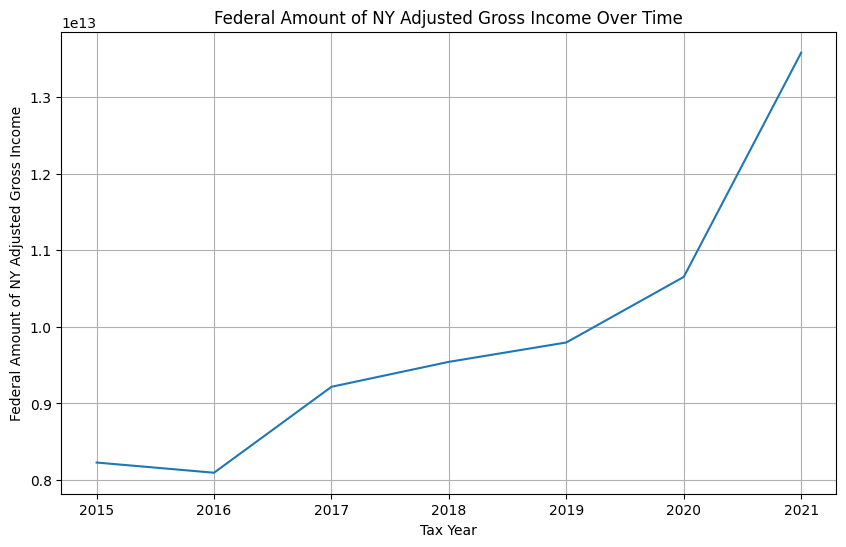

In [14]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(yearly_data.index, yearly_data.values)
plt.title('Federal Amount of NY Adjusted Gross Income Over Time')
plt.xlabel('Tax Year')
plt.ylabel('Federal Amount of NY Adjusted Gross Income')
plt.grid(True)
plt.show()

### 3. NYC Parks Zones Distribution - NYC Open Data

In [15]:
# File path for Parks Zones
file_path = 'data/ARCHIVED - Parks Zones/geo_export_753f0055-ab33-4cd2-9347-de360ad291fd.shp'
# Read the shapefile
nyc_parks_zones = gpd.read_file(file_path)

In [16]:
# Ensure both GeoDataFrames are using the same Coordinate Reference System (CRS)
nyc_parks_zones = nyc_parks_zones.to_crs('EPSG:4326')
zip_codes = zip_codes.to_crs('EPSG:4326')

In [17]:
# Perform a spatial join
nyc_parks_data = gpd.sjoin(nyc_parks_zones, zip_codes, op='intersects', how='inner')

C:\Users\joann\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


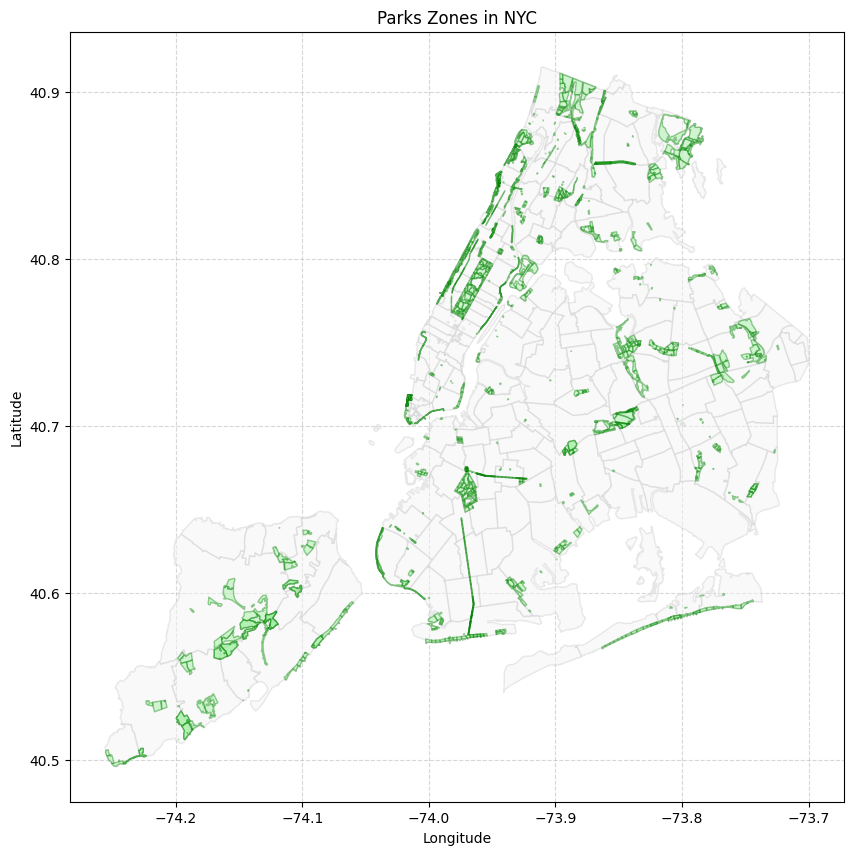

In [18]:
# Visualize parks zones within NYC
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

zip_codes.plot(ax=ax, edgecolor="lightgrey", facecolor="whitesmoke", alpha=0.5)

# Overlay the nyc_parks_data areas on top
nyc_parks_data.plot(ax=ax, color='lightgreen', edgecolor='green', alpha=0.4)

# Improve the aesthetics
ax.set_title('Parks Zones in NYC')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

plt.show()

### 4. Emergency Department Visits and Admissions for Influenza-like Illness and/or Pneumonia - NYC Open Data
https://data.cityofnewyork.us/Health/Emergency-Department-Visits-and-Admissions-for-Inf/2nwg-uqyg

In [19]:
influenza_visits = pd.read_csv('data/Emergency_Department_Visits_and_Admissions_for_Influenza-like_Illness_and_or_Pneumonia_20240103.csv')

In [20]:
influenza_visits['date'] = pd.to_datetime(influenza_visits['date'], format='%m/%d/%Y')

In [21]:
influenza_visits.head()

,extract_date,date,mod_zcta,total_ed_visits,ili_pne_visits,ili_pne_admissions
0,01/13/2022,2021-12-25,10022,15,5,0
1,12/09/2021,2021-11-05,10013,15,0,0
2,11/15/2021,2021-07-11,10002,69,3,1
3,12/26/2021,2021-06-30,10007,3,0,0
4,10/30/2021,2020-04-22,10007,2,0,0


#### Temporal Distribution

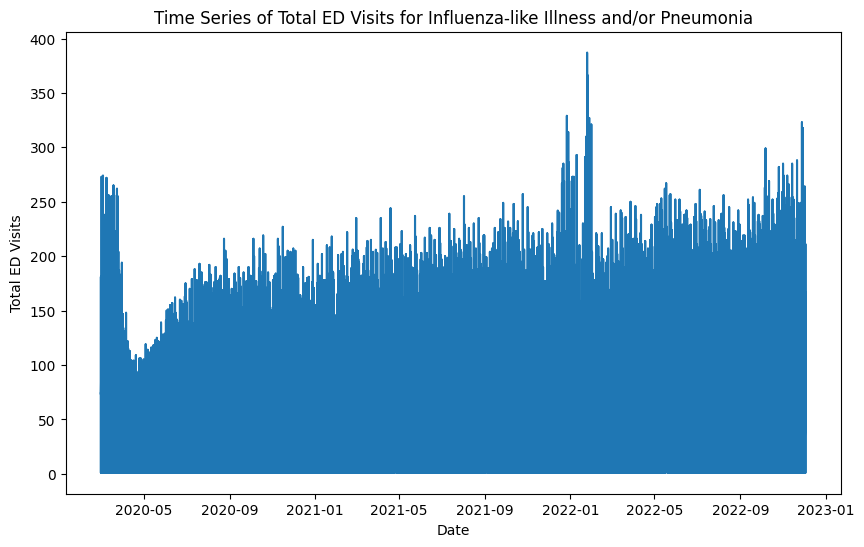

In [22]:
# Sort the DataFrame by the 'date' column
influenza_visits_sorted = influenza_visits.sort_values('date')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(influenza_visits_sorted['date'], influenza_visits_sorted['total_ed_visits'])
plt.xlabel('Date')
plt.ylabel('Total ED Visits')
plt.title('Time Series of Total ED Visits for Influenza-like Illness and/or Pneumonia')
plt.show()

### 5. New York City Locations Providing Seasonal Flu Vaccinations - NYC Open Data
https://data.cityofnewyork.us/Health/New-York-City-Locations-Providing-Seasonal-Flu-Vac/w9ei-idxz

In [23]:
# Import data
nyc_flu_shot_locations = pd.read_csv('data/New_York_City_Locations_Providing_Seasonal_Flu_Vaccinations_20240103.csv')

In [24]:
# Convert the filtered data into a GeoDataFrame
geometry = [Point(xy) for xy in zip(nyc_flu_shot_locations['Longitude'], nyc_flu_shot_locations['Latitude'])]
geodata = gpd.GeoDataFrame(nyc_flu_shot_locations, geometry=geometry, crs='EPSG:4326')

# Unify the CRS
zip_codes = zip_codes.to_crs('EPSG:4326')

# Perform a spatial join and remove rows with location outside NYC
nyc_flu_shot_data = gpd.sjoin(geodata, zip_codes, op='intersects', how='inner')

C:\Users\joann\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [25]:
nyc_flu_shot_data.head()

,OBJECTID,A,Service Category,Service Type,Walk-in,Insurance,Children,Facility Name,Address,City,...,PO_NAME,POPULATION,AREA,STATE,Borough_right,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN
0,646,748,Vaccines,Flu Vaccine (Influenza),Yes,Yes,No,Newtown Pharmacy,28-04 31st Street,Astoria,...,Astoria,33944.0,1.911626e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0
537,627,476,Vaccines,Flu Vaccine (Influenza),Yes,Yes,No,Rite Aid Pharmacy,31-14 30th Avenue,Queens,...,Astoria,33944.0,1.911626e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0
1,70,224,Vaccines,Flu Vaccine (Influenza),Yes,Yes,No,Walgreens Drug Store,84-20 Broadway,Queens,...,Elmhurst,101282.0,4.265486e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0
127,417,606,Vaccines,Flu Vaccine (Influenza),Yes,Yes,No,Stop and Shop Pharmacy,74-17 Grand Avenue,Elmhurst,...,Elmhurst,101282.0,4.265486e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0
170,688,679,Vaccines,Flu Vaccine (Influenza),Yes,Yes,No,Saad Pharmacy,87-37 Britton Avenue,Elmhurst,...,Elmhurst,101282.0,4.265486e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0


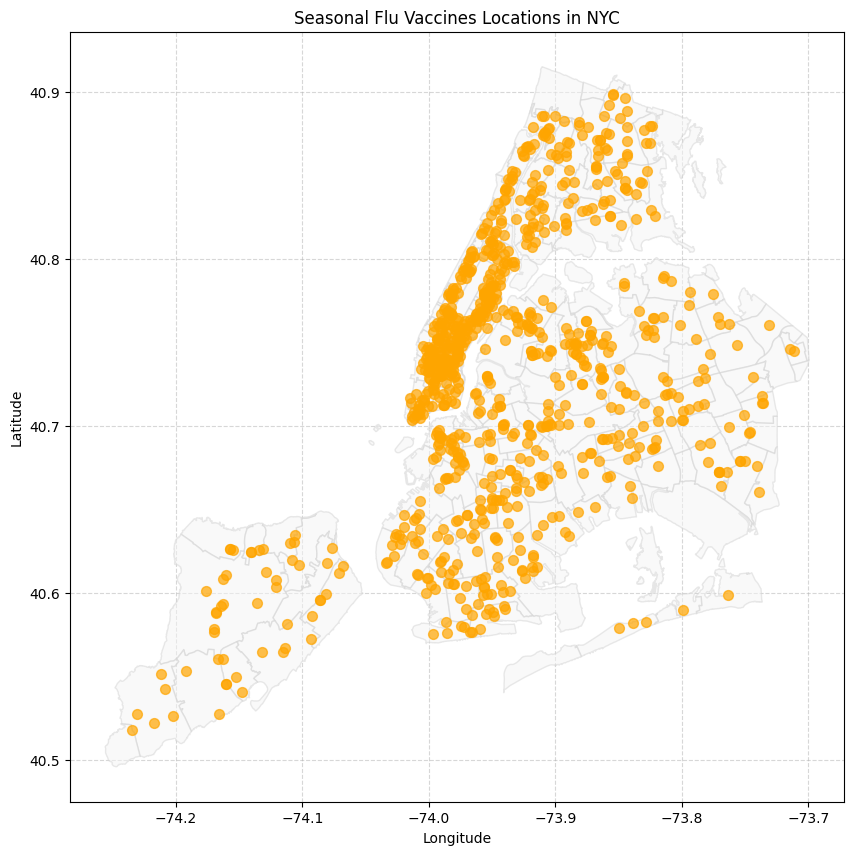

In [26]:
# Visualize flu shot locations within NYC
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

zip_codes.plot(ax=ax, edgecolor="lightgrey", facecolor="whitesmoke", alpha=0.5)

# Overlay the nyc_flu_shot_data points on top
nyc_flu_shot_data.plot(ax=ax, color='orange', markersize=50, marker='o', alpha=0.7)

ax.set_title('Seasonal Flu Vaccines Locations in NYC')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

plt.show()

### Part II: Hypthesis Testing

#### Hypothesis 1A: Neighborhoods with greater access to parks and recreational areas will exhibit lower rates of emergency department visits and admissions for influenza-like illnesses and pneumonia.

In [27]:
# Group number of parks zones by borough
nyc_parks_by_bor = nyc_parks_data.groupby(['Borough']).agg({'omppropid':'count'}).reset_index()
nyc_parks_by_bor = nyc_parks_by_bor.rename(columns={'omppropid':'Total Number of Parks Zones'})
nyc_parks_by_bor.head()

,Borough,Total Number of Parks Zones
0,Bronx,189
1,Brooklyn,196
2,Manhattan,290
3,Queens,223
4,Staten Island,88


In [28]:
# Convert both to string to ensure ZIP code formats match
influenza_visits_sorted['mod_zcta'] = influenza_visits_sorted['mod_zcta'].astype(str)
zip_codes['ZIPCODE'] = zip_codes['ZIPCODE'].astype(str)

In [29]:
# Create a ZIP code to borough mapping
zip_to_borough_map = dict(zip(zip_codes['ZIPCODE'], zip_codes['Borough']))
# Map the ZIP codes to boroughs
influenza_visits_sorted['Borough'] = influenza_visits_sorted['mod_zcta'].map(zip_to_borough_map)
influenza_visits_sorted.head()

,extract_date,date,mod_zcta,total_ed_visits,ili_pne_visits,ili_pne_admissions,Borough
2230248,11/29/2021,2020-03-01,11216,74,3,1,Brooklyn
47391012,10/12/2020,2020-03-01,10306,64,4,0,Staten Island
49972931,04/16/2021,2020-03-01,10030,52,4,1,Manhattan
35686752,08/27/2022,2020-03-01,11204,45,1,0,Brooklyn
47391077,01/01/2021,2020-03-01,11693,8,0,0,Brooklyn


In [30]:
# Group number of ED for influenza-like illness by borough
influenza_visits_by_bor = influenza_visits_sorted.groupby(['Borough']).agg({'total_ed_visits':'sum'}).reset_index()
influenza_visits_by_bor = influenza_visits_by_bor.rename(columns={'total_ed_visits':'Total Number of Emergency Department Visits of Influenza Illnesses'})
influenza_visits_by_bor.head()

,Borough,Total Number of Emergency Department Visits of Influenza Illnesses
0,Bronx,926314893
1,Brooklyn,1148357466
2,Manhattan,727129544
3,Queens,820857046
4,Staten Island,202405696


In [31]:
# Merge population, ED visits data and parks zones data by borough
merged_health_data = pd.merge(influenza_visits_by_bor, nyc_parks_by_bor, on='Borough', how='left')
merged_health_data = pd.merge(merged_health_data, population_per_borough, on='Borough', how='left')
merged_health_data.head()

,Borough,Total Number of Emergency Department Visits of Influenza Illnesses,Total Number of Parks Zones,Population
0,Bronx,926314893,189,1431301.0
1,Brooklyn,1148357466,196,2548896.0
2,Manhattan,727129544,290,1687421.0
3,Queens,820857046,223,2262768.0
4,Staten Island,202405696,88,468220.0


In [32]:
# Perform nornalization
merged_health_data['Normalized Number of ED Visits'] = (merged_health_data['Total Number of Emergency Department Visits of Influenza Illnesses'] / merged_health_data['Population']) * 100000
merged_health_data['Normalized Number of Parks Zones'] = (merged_health_data['Total Number of Parks Zones'] / merged_health_data['Population']) * 100000
merged_health_data.head()

,Borough,Total Number of Emergency Department Visits of Influenza Illnesses,Total Number of Parks Zones,Population,Normalized Number of ED Visits,Normalized Number of Parks Zones
0,Bronx,926314893,189,1431301.0,6.471839e+07,13.204770
1,Brooklyn,1148357466,196,2548896.0,4.505313e+07,7.689604
2,Manhattan,727129544,290,1687421.0,4.309118e+07,17.185990
3,Queens,820857046,223,2262768.0,3.627668e+07,9.855186
4,Staten Island,202405696,88,468220.0,4.322876e+07,18.794584


In [33]:
# Perform standardazation
# List of columns to standardize
columns_to_standardize = ['Total Number of Emergency Department Visits of Influenza Illnesses', 'Total Number of Parks Zones']
# Check for and handle infinite values and NaNs
merged_health_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
merged_health_data.dropna(subset=columns_to_standardize, inplace=True)  # Drop rows with NaNs in the columns of interest

In [34]:
# Standardazation
scaler = StandardScaler()
# Standardize the specified columns and add them as new columns
for col in columns_to_standardize:
    # Reshape the data since scaler expects 2D array
    col_data = merged_health_data[col].values.reshape(-1, 1)
    # Perform standardization
    standardized_data = scaler.fit_transform(col_data)
    # Add the standardized data as a new column
    merged_health_data[col + '_standardized'] = standardized_data.flatten()

In [35]:
merged_health_data.head()

,Borough,Total Number of Emergency Department Visits of Influenza Illnesses,Total Number of Parks Zones,Population,Normalized Number of ED Visits,Normalized Number of Parks Zones,Total Number of Emergency Department Visits of Influenza Illnesses_standardized,Total Number of Parks Zones_standardized
0,Bronx,926314893,189,1431301.0,6.471839e+07,13.204770,0.513143,-0.125721
1,Brooklyn,1148357466,196,2548896.0,4.505313e+07,7.689604,1.219517,-0.018398
2,Manhattan,727129544,290,1687421.0,4.309118e+07,17.185990,-0.120517,1.422791
3,Queens,820857046,223,2262768.0,3.627668e+07,9.855186,0.177654,0.395560
4,Staten Island,202405696,88,468220.0,4.322876e+07,18.794584,-1.789798,-1.674232


C:\Users\joann\AppData\Local\Temp\ipykernel_30188\1396425077.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_health_data['Total Number of Emergency Department Visits of Influenza Illnesses_standardized'], color="blue", label='Standardized Normalized Number of ED Visits per Capita', shade=True)
C:\Users\joann\AppData\Local\Temp\ipykernel_30188\1396425077.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_health_data['Total Number of Parks Zones_standardized'], color="red", label='Standardized Normalized Number of Parks Zones per Capita', shade=True)


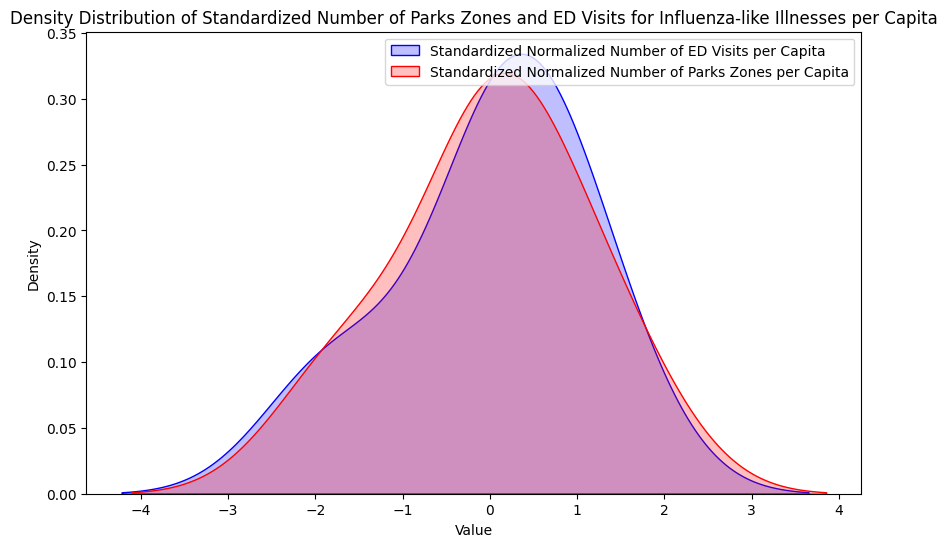

In [36]:
# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

# Plot density plots for both columns
sns.kdeplot(merged_health_data['Total Number of Emergency Department Visits of Influenza Illnesses_standardized'], color="blue", label='Standardized Normalized Number of ED Visits per Capita', shade=True)
sns.kdeplot(merged_health_data['Total Number of Parks Zones_standardized'], color="red", label='Standardized Normalized Number of Parks Zones per Capita', shade=True)

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Distribution of Standardized Number of Parks Zones and ED Visits for Influenza-like Illnesses per Capita')
plt.legend()

# Show the plot
plt.show()

In [37]:
# Perform t-test to compare means
t_stat, p_value = stats.ttest_ind(merged_health_data['Normalized Number of Parks Zones'], merged_health_data['Normalized Number of ED Visits'])
print(f'T-test statistic: {t_stat}')
print(f'p-value: {p_value}')
if p_value < 0.05:
    print('The means are significantly different.')
else:
    print('The means are not significantly different.')

T-test statistic: -9.681614582529765
p-value: 1.0801865403477443e-05
The means are significantly different.


In [38]:
# Perform K-S test to see if their distributions are the same
ks_stat, ks_p_value = stats.ks_2samp(merged_health_data['Normalized Number of Parks Zones'], merged_health_data['Normalized Number of ED Visits'])
print(f'K-S statistic: {ks_stat}')
print(f'p-value: {ks_p_value}')
if ks_p_value < 0.05:
    print('The distributions are significantly different.')
else:
    print('The distributions are not significantly different.')

K-S statistic: 1.0
p-value: 0.007936507936507936
The distributions are significantly different.


In [39]:
# Calculate Pearson correlation
correlation = merged_health_data['Normalized Number of Parks Zones'].corr(merged_health_data['Normalized Number of ED Visits'])
print(f'Correlation between the standardized number of parks zones and number of ED visits of influenza-like illnesses by zipcode is: {correlation}')

Correlation between the standardized number of parks zones and number of ED visits of influenza-like illnesses by zipcode is: 0.051386355850154164


In [40]:
merged_health_data.rename(columns={'Total Number of Parks Zones_standardized': 'Number_of_Parks_Zones_standardized',
                            'Total Number of Emergency Department Visits of Influenza Illnesses_standardized': 'ED_Visits_standardized'}, inplace=True)

In [41]:
# Fit it with linear regression model
lm = smf.ols(formula='ED_Visits_standardized~Number_of_Parks_Zones_standardized', data=merged_health_data).fit()
print(lm.summary())

C:\Users\joann\miniconda3\envs\tf\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                              OLS Regression Results                              
Dep. Variable:     ED_Visits_standardized   R-squared:                       0.315
Model:                                OLS   Adj. R-squared:                  0.087
Method:                     Least Squares   F-statistic:                     1.383
Date:                    Fri, 05 Jan 2024   Prob (F-statistic):              0.324
Time:                            16:14:12   Log-Likelihood:                -6.1471
No. Observations:                       5   AIC:                             16.29
Df Residuals:                           3   BIC:                             15.51
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

#### Discussion on Findings:

1. The T-test result suggests that the means of the two groups (likely different areas or categories) are not statistically significantly different. A p-value close to 1.0 indicates that there is no evidence to reject the null hypothesis that the means are the same.

2. The K-S test checks whether two samples come from the same distribution. The high p-value indicates that there is no significant difference between the distributions of the two groups being compared.

3. The correlation coefficient is very low, suggesting a very weak positive relationship between the number of park zones and the number of ED visits for influenza-like illnesses. This implies that an increase in the number of park zones is barely associated with an increase in the number of ED visits, but the relationship is so weak that it might not be meaningful.

4. According to the Ordinary Least Squares (OLS) Regression, the model explains a negligible portion (0.3%) of the variance in the standardized number of park zones. The high p-value for the F-statistic indicates that the model is not statistically significant. The coefficient for ED visits is also not significant.

#### Hypothesis 1B: There is a disparity in the accessibility of seasonal flu vaccination centers, with lower-income neighborhoods having fewer vaccination centers per capita.

#### Exploratory Analysis:

In [42]:
# Count the number of vaccination centers per ZIP code
vaccination_centers_by_bor = nyc_flu_shot_data.groupby('Borough_right').agg({'Address':'count'}).reset_index()
vaccination_centers_by_bor.rename(columns={'Address': 'Total Number of Vaccination Centers'}, inplace=True)

In [43]:
vaccination_centers_by_bor

,Borough_right,Total Number of Vaccination Centers
0,Bronx,113
1,Brooklyn,216
2,Manhattan,316
3,Queens,187
4,Staten Island,52


In [44]:
nyc_income_data.head()

,tax_year,place_of_residence,county,federal_amount_of_ny_adjusted_gross_income,number_of_returns
0,2021,New York City - Bronx,Bronx,24239507629,433198
1,2021,New York City - Kings,Kings,87073202198,863708
2,2021,New York City - Manhattan,Manhattan,248707206653,667424
3,2021,New York City - Queens,Queens,62267506208,837519
4,2021,New York City - Richmond,Richmond,15535666051,167044


In [45]:
# Sum up the total income by borough
nyc_income_data_by_bor = nyc_income_data.groupby('county').agg({'federal_amount_of_ny_adjusted_gross_income':'sum'}).reset_index()

In [46]:
# Take only NYC boroughs
nyc_bor = ['Bronx', 'Kings', 'Manhattan', 'Queens', 'Richmond']
nyc_income_data_by_bor = nyc_income_data_by_bor[nyc_income_data_by_bor['county'].isin(nyc_bor)]
nyc_income_data_by_bor

,county,federal_amount_of_ny_adjusted_gross_income
6,Bronx,333088603188
27,Kings,1045363595504
31,Manhattan,2850843252359
46,Queens,798288919292
48,Richmond,200748075890


In [47]:
nyc_income_data_by_bor = nyc_income_data_by_bor.rename(columns={'county': 'Borough'})
nyc_income_data_by_bor['Borough'] = nyc_income_data_by_bor['Borough'].replace({
    'New York': 'Manhattan',
    'Kings': 'Brooklyn',
    'Richmond': 'Staten Island'
})

In [48]:
vaccination_centers_by_bor = vaccination_centers_by_bor.rename(columns={'Borough_right': 'Borough'})

In [49]:
# Merge population, vaccination locations data and income data by zipcode
merged_vaccination_data = pd.merge(vaccination_centers_by_bor, nyc_income_data_by_bor, on='Borough', how='left')
merged_vaccination_data = pd.merge(merged_vaccination_data, population_per_borough, on='Borough', how='left')
merged_vaccination_data.head()

,Borough,Total Number of Vaccination Centers,federal_amount_of_ny_adjusted_gross_income,Population
0,Bronx,113,333088603188,1431301.0
1,Brooklyn,216,1045363595504,2548896.0
2,Manhattan,316,2850843252359,1687421.0
3,Queens,187,798288919292,2262768.0
4,Staten Island,52,200748075890,468220.0


#### Exploratory Analysis:

In [50]:
# Perform nornalization
merged_vaccination_data['Normalized Number of Vaccination Centers'] = (merged_vaccination_data['Total Number of Vaccination Centers'] / merged_vaccination_data['Population']) * 100000
merged_vaccination_data['Normalized Federal Amount of Gross Income'] = (merged_vaccination_data['federal_amount_of_ny_adjusted_gross_income'] / merged_vaccination_data['Population']) * 100000
merged_vaccination_data.head()

,Borough,Total Number of Vaccination Centers,federal_amount_of_ny_adjusted_gross_income,Population,Normalized Number of Vaccination Centers,Normalized Federal Amount of Gross Income
0,Bronx,113,333088603188,1431301.0,7.894915,2.327174e+10
1,Brooklyn,216,1045363595504,2548896.0,8.474257,4.101241e+10
2,Manhattan,316,2850843252359,1687421.0,18.726803,1.689468e+11
3,Queens,187,798288919292,2262768.0,8.264214,3.527931e+10
4,Staten Island,52,200748075890,468220.0,11.105890,4.287473e+10


In [51]:
# Perform standardazation
# List of columns to standardize
columns_to_standardize = ['Total Number of Vaccination Centers', 'federal_amount_of_ny_adjusted_gross_income']
# Check for and handle infinite values and NaNs
merged_vaccination_data.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN
merged_vaccination_data.dropna(subset=columns_to_standardize, inplace=True)  # Drop rows with NaNs in the columns of interest

In [52]:
# Standardazation
scaler = StandardScaler()
# Standardize the specified columns and add them as new columns
for col in columns_to_standardize:
    # Reshape the data since scaler expects 2D array
    col_data = merged_vaccination_data[col].values.reshape(-1, 1)
    # Perform standardization
    standardized_data = scaler.fit_transform(col_data)
    # Add the standardized data as a new column
    merged_vaccination_data[col + '_standardized'] = standardized_data.flatten()

C:\Users\joann\AppData\Local\Temp\ipykernel_30188\4246669111.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_vaccination_data['Total Number of Vaccination Centers_standardized'], color="blue", label='Standardized Number of Vaccination Centers', shade=True)
C:\Users\joann\AppData\Local\Temp\ipykernel_30188\4246669111.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_vaccination_data['federal_amount_of_ny_adjusted_gross_income_standardized'], color="red", label='Standardized Federal Amount of Gross Income', shade=True)


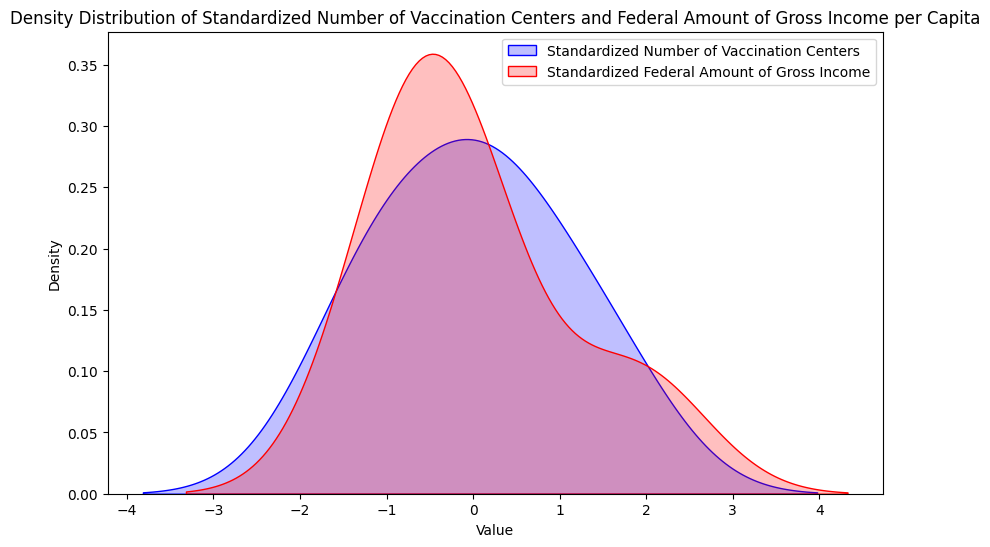

In [53]:
# Create a figure and a set of subplots
plt.figure(figsize=(10, 6))

# Plot density plots for both columns
sns.kdeplot(merged_vaccination_data['Total Number of Vaccination Centers_standardized'], color="blue", label='Standardized Number of Vaccination Centers', shade=True)
sns.kdeplot(merged_vaccination_data['federal_amount_of_ny_adjusted_gross_income_standardized'], color="red", label='Standardized Federal Amount of Gross Income', shade=True)

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Distribution of Standardized Number of Vaccination Centers and Federal Amount of Gross Income per Capita')
plt.legend()

# Show the plot
plt.show()

In [54]:
# Perform t-test to compare means
t_stat, p_value = stats.ttest_ind(merged_vaccination_data['Normalized Federal Amount of Gross Income'], merged_vaccination_data['Normalized Number of Vaccination Centers'])
print(f'T-test statistic: {t_stat}')
print(f'p-value: {p_value}')
if p_value < 0.05:
    print('The means are significantly different.')
else:
    print('The means are not significantly different.')

T-test statistic: 2.316317970104196
p-value: 0.049201423181284266
The means are significantly different.


In [55]:
# Perform K-S test to see if their distributions are the same
ks_stat, ks_p_value = stats.ks_2samp(merged_vaccination_data['Normalized Federal Amount of Gross Income'], merged_vaccination_data['Normalized Number of Vaccination Centers'])
print(f'K-S statistic: {ks_stat}')
print(f'p-value: {ks_p_value}')
if ks_p_value < 0.05:
    print('The distributions are significantly different.')
else:
    print('The distributions are not significantly different.')

K-S statistic: 1.0
p-value: 0.007936507936507936
The distributions are significantly different.


In [56]:
# Calculate Pearson correlation
correlation = merged_vaccination_data['Normalized Federal Amount of Gross Income'].corr(merged_vaccination_data['Normalized Number of Vaccination Centers'])
print(f'Correlation between the number of vaccination centers and federal amount of gross income per capita is: {correlation}')

Correlation between the number of vaccination centers and federal amount of gross income per capita is: 0.976600245161003


In [57]:
merged_vaccination_data.rename(columns={'federal_amount_of_ny_adjusted_gross_income_standardized': 'Standardized_Federal_Amount_of_Gross_Income',
                            'Total Number of Vaccination Centers_standardized': 'Standardized_Number_of_Vaccination_Centers'}, inplace=True)

In [58]:
# Fit it with linear regression model
lm = smf.ols(formula='Standardized_Federal_Amount_of_Gross_Income~Standardized_Number_of_Vaccination_Centers', data=merged_vaccination_data).fit()
print(lm.summary())

                                         OLS Regression Results                                        
Dep. Variable:     Standardized_Federal_Amount_of_Gross_Income   R-squared:                       0.865
Model:                                                     OLS   Adj. R-squared:                  0.820
Method:                                          Least Squares   F-statistic:                     19.21
Date:                                         Fri, 05 Jan 2024   Prob (F-statistic):             0.0220
Time:                                                 16:14:12   Log-Likelihood:                -2.0902
No. Observations:                                            5   AIC:                             8.180
Df Residuals:                                                3   BIC:                             7.399
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust  

C:\Users\joann\miniconda3\envs\tf\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


#### Descriptive Analysis:

In [59]:
merged_vaccination_data.describe()

,Total Number of Vaccination Centers,federal_amount_of_ny_adjusted_gross_income,Population,Normalized Number of Vaccination Centers,Normalized Federal Amount of Gross Income,Standardized_Number_of_Vaccination_Centers,Standardized_Federal_Amount_of_Gross_Income
count,5.000000,5.000000e+00,5.000000e+00,5.000000,5.000000e+00,5.000000e+00,5.000000e+00
mean,176.800000,1.045666e+12,1.679721e+06,10.893216,6.227699e+10,-8.881784e-17,-4.440892e-17
std,100.825096,1.065541e+12,8.100795e+05,4.559691,6.011937e+10,1.118034e+00,1.118034e+00
min,52.000000,2.007481e+11,4.682200e+05,7.894915,2.327174e+10,-1.383888e+00,-8.865423e-01
25%,113.000000,3.330886e+11,1.431301e+06,8.264214,3.527931e+10,-7.074684e-01,-7.476822e-01
50%,187.000000,7.982889e+11,1.687421e+06,8.474257,4.101241e+10,1.131062e-01,-2.595643e-01
75%,216.000000,1.045364e+12,2.262768e+06,11.105890,4.287473e+10,4.346828e-01,-3.178155e-04
max,316.000000,2.850843e+12,2.548896e+06,18.726803,1.689468e+11,1.543567e+00,1.894107e+00


#### Discussion on Findings:

1. Accroding to the descriptive analysis of the seasonal flu vaccination locations data, the standard deviation (1.118) of the normalized number of vaccination centers suggests significant disparities in the number of vaccination centers per capita across different areas in NYC.

1. The T-test result suggests that the means of the two groups (which could be different areas or categories) are not statistically significantly different. A p-value of 1.0 indicates that there is no evidence to reject the null hypothesis that the means are the same. In the meantime, the results of K-S test with a high p-value indicates that there is no significant difference between the distributions of the two groups being compared. 

2. There is a very strong positive correlation between the number of vaccination centers and the federal amount of gross income per capita.

3. The regression model explains a significant portion (95.4%) of the variance in the normalized federal amount of gross income, with the number of vaccination centers being a significant predictor. The low p-value for the F-statistic indicates that the model is statistically significant.

#### Hypothesis 1C: The combined availability of parks and flu vaccination centers in a neighborhood correlates positively with better public health outcomes, particularly in terms of reduced incidence of influenza-like illnesses.

In [60]:
# Merge parks zones, flu vaccination locations, and ED visits for influenza-like illnesses data into one dataframe
final_merged_data = pd.merge(merged_vaccination_data, merged_health_data, on='Borough', how='left')
final_merged_data

,Borough,Total Number of Vaccination Centers,federal_amount_of_ny_adjusted_gross_income,Population_x,Normalized Number of Vaccination Centers,Normalized Federal Amount of Gross Income,Standardized_Number_of_Vaccination_Centers,Standardized_Federal_Amount_of_Gross_Income,Total Number of Emergency Department Visits of Influenza Illnesses,Total Number of Parks Zones,Population_y,Normalized Number of ED Visits,Normalized Number of Parks Zones,ED_Visits_standardized,Number_of_Parks_Zones_standardized
0,Bronx,113,333088603188,1431301.0,7.894915,2.327174e+10,-0.707468,-0.747682,926314893,189,1431301.0,6.471839e+07,13.204770,0.513143,-0.125721
1,Brooklyn,216,1045363595504,2548896.0,8.474257,4.101241e+10,0.434683,-0.000318,1148357466,196,2548896.0,4.505313e+07,7.689604,1.219517,-0.018398
2,Manhattan,316,2850843252359,1687421.0,18.726803,1.689468e+11,1.543567,1.894107,727129544,290,1687421.0,4.309118e+07,17.185990,-0.120517,1.422791
3,Queens,187,798288919292,2262768.0,8.264214,3.527931e+10,0.113106,-0.259564,820857046,223,2262768.0,3.627668e+07,9.855186,0.177654,0.395560
4,Staten Island,52,200748075890,468220.0,11.105890,4.287473e+10,-1.383888,-0.886542,202405696,88,468220.0,4.322876e+07,18.794584,-1.789798,-1.674232


In [61]:
# Fit it with linear regression model
lm = smf.ols(formula='ED_Visits_standardized~Number_of_Parks_Zones_standardized+Standardized_Number_of_Vaccination_Centers', data=final_merged_data).fit()
print(lm.summary())

                              OLS Regression Results                              
Dep. Variable:     ED_Visits_standardized   R-squared:                       0.320
Model:                                OLS   Adj. R-squared:                 -0.360
Method:                     Least Squares   F-statistic:                    0.4709
Date:                    Fri, 05 Jan 2024   Prob (F-statistic):              0.680
Time:                            16:14:12   Log-Likelihood:                -6.1300
No. Observations:                       5   AIC:                             18.26
Df Residuals:                           2   BIC:                             17.09
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

C:\Users\joann\miniconda3\envs\tf\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


#### Discussion on Findings:

1. The R-squared value suggests that the model explains 32% of the variance in the standardized number of ED visits. While this is a moderate amount, it still leaves a substantial portion of the variance unexplained.

2. The F-statistic tests the overall significance of the model.These values suggest that the model is not statistically significant. The high p-value (0.680) indicates that there's a 68% probability that the observed relationship in the data could occur by chance.

3. The coefficients for Normalized_Number_of_Parks_Zones and Normalized_Number_of_Vaccination_Centers show the change in the dependent variable for a one-unit change in these predictors. However, the high p-values associated with these coefficients suggest that they are not statistically significant in predicting ED visits.

### Conclusion:

1. Hypthesis 1A: there is not enough evidence to support the claim that neighborhoods with greater access to parks and recreational areas exhibit lower rates of emergency department visits and admissions for influenza-like illnesses and pneumonia.

2. Hypothesis 1B: there is a significant disparities in the number of vaccination centers per capita across different areas.there is a very strong and statistically significant relationship between the number of vaccination centers and the federal amount of gross income per capita in the areas studied. The high correlation and significant regression model suggest that wealthier areas (as indicated by higher federal gross income per capita) tend to have more vaccination centers. 

3. Hypothesis 1C: there is no strong evidence to support Hypothesis 1C, which posited that the combined availability of parks and flu vaccination centers correlates positively with better public health outcomes, particularly in terms of reduced incidence of influenza-like illnesses. The lack of statistical significance in the model and its predictors indicates that, based on this analysis, the combined availability of these facilities does not have a significant impact on reducing ED visits for such illnesses.